### This script shows a basic example of training a SentenceTransformer multimodal model with omics data stored in anndata format

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [113]:
from mmcontext.utils import setup_logging

setup_logging()

<RootLogger root (INFO)>

In [114]:
omics_model_cfg = {
    "embedding_dim": 64,
    "hidden_dim": 128,
    "num_layers": 1,
    "num_heads": 0,
    "use_self_attention": False,
    "activation": "relu",
    "dropout": 0.1,
}

In [115]:
from mmcontext.models import MMContextEncoder

model = MMContextEncoder(
    text_encoder_name="pritamdeka/S-BioBert-snli-multinli-stsb",
    omics_encoder_cfg=omics_model_cfg,
    processor_obsm_key="X_scvi",
)

2025-02-13 08:08:48,926 - mmcontext.pp.MMContextProcessor - INFO - Initialized AnnDataRetrievalProcessor. Will use embeddings from obsm_key: X_scvi as initial embeddings.


In [88]:
from sentence_transformers import SentenceTransformer

modules = [model]
model = SentenceTransformer(modules=modules)

2025-02-12 12:54:19,743 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps


In [89]:
from datasets import load_dataset

dataset_name = "geo_7k_cellxgene_3_5k_pairs"
dataset = load_dataset(f"jo-mengr/{dataset_name}")
# test_dataset = load_dataset("jo-mengr/human_pancreas_norm_complexBatch_single")

In [90]:
from datasets import load_dataset
from sentence_transformers import (
    SentenceTransformer,
    SentenceTransformerModelCardData,
    SentenceTransformerTrainer,
    SentenceTransformerTrainingArguments,
    losses,
)
from sentence_transformers.evaluation import BinaryClassificationEvaluator
from sentence_transformers.losses import MultipleNegativesRankingLoss
from sentence_transformers.training_args import BatchSamplers

# 3. Load a dataset to finetune on
train_dataset = dataset["train"]
eval_dataset = dataset["val"]
# test_dataset = test_dataset["train"]

# 4. Define a loss function
loss = losses.ContrastiveLoss(model=model)

# 5. (Optional) Specify training arguments
args = SentenceTransformerTrainingArguments(
    # Required parameter:
    output_dir="../../data/models/mmcontext_trained",
    # Optional training parameters:
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=False,  # Set to True if you have a GPU that supports BF16
    # batch_sampler=BatchSamplers.NO_DUPLICATES,  # MultipleNegativesRankingLoss benefits from no duplicate samples in a batch
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=2,
    logging_steps=100,
    run_name="mmcontext",  # Will be used in W&B if `wandb` is installed
)

# 6. (Optional) Create an evaluator & evaluate the base model
dev_evaluator = BinaryClassificationEvaluator(
    sentences1=eval_dataset["anndata_ref"],
    sentences2=eval_dataset["caption"],
    labels=eval_dataset["label"],
)
dev_evaluator(model)

# 7. Create a trainer & train
trainer = SentenceTransformerTrainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    loss=loss,
    evaluator=dev_evaluator,
    extra_feature_keys=["omics_representation"],
)
trainer.train()

## (Optional) Evaluate the trained model on the test set
# test_evaluator = TripletEvaluator(
#    anchors=test_dataset["anchor"],
#    positives=test_dataset["positive"],
#    negatives=test_dataset["negative"],
#    name="all-nli-test",
# )
# test_evaluator(model)

## 8. Save the trained model
# model.save_pretrained("models/mpnet-base-all-nli-triplet/final")

# 9. (Optional) Push it to the Hugging Face Hub
# model.push_to_hub("mpnet-base-all-nli-triplet")

2025-02-12 12:54:30,794 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset:
2025-02-12 12:54:32,116 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             67.14	(Threshold: 0.2245)
2025-02-12 12:54:32,117 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   50.65	(Threshold: -0.1916)
2025-02-12 12:54:32,117 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            33.95
2025-02-12 12:54:32,117 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               99.71
2025-02-12 12:54:32,118 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    38.35
2025-02-12 12:54:32,118 - sentence_transformers.evaluation.

{'loss': 0.0639, 'grad_norm': 0.4335985481739044, 'learning_rate': 1.849340866290019e-05, 'epoch': 0.17}


2025-02-12 12:54:54,563 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.1692047377326565 after 100 steps:
2025-02-12 12:54:55,206 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             68.10	(Threshold: 0.7458)
2025-02-12 12:54:55,206 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   59.93	(Threshold: 0.5044)
2025-02-12 12:54:55,207 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            43.98
2025-02-12 12:54:55,207 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               94.00
2025-02-12 12:54:55,207 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    49.57
2025-02-12 12:54

{'eval_loss': 0.02680368348956108, 'eval_cosine_accuracy': 0.680952380952381, 'eval_cosine_accuracy_threshold': 0.7457666993141174, 'eval_cosine_f1': 0.5992714025500909, 'eval_cosine_f1_threshold': 0.5043587684631348, 'eval_cosine_precision': 0.43983957219251335, 'eval_cosine_recall': 0.94, 'eval_cosine_ap': 0.4956614704311536, 'eval_cosine_mcc': 0.35557288273592974, 'eval_runtime': 3.3151, 'eval_samples_per_second': 316.731, 'eval_steps_per_second': 19.909, 'epoch': 0.17}


 34%|███▍      | 200/591 [00:40<01:02,  6.25it/s]

{'loss': 0.0252, 'grad_norm': 0.4395189583301544, 'learning_rate': 1.4726930320150661e-05, 'epoch': 0.34}


2025-02-12 12:55:19,590 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.338409475465313 after 200 steps:
2025-02-12 12:55:20,250 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             68.00	(Threshold: 0.7361)
2025-02-12 12:55:20,250 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   60.62	(Threshold: 0.7024)
2025-02-12 12:55:20,250 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            49.46
2025-02-12 12:55:20,251 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               78.29
2025-02-12 12:55:20,251 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    50.50
2025-02-12 12:55:

{'eval_loss': 0.02560090273618698, 'eval_cosine_accuracy': 0.68, 'eval_cosine_accuracy_threshold': 0.7361286878585815, 'eval_cosine_f1': 0.6061946902654867, 'eval_cosine_f1_threshold': 0.7024479508399963, 'eval_cosine_precision': 0.49458483754512633, 'eval_cosine_recall': 0.7828571428571428, 'eval_cosine_ap': 0.505006907848245, 'eval_cosine_mcc': 0.36151313023588116, 'eval_runtime': 3.844, 'eval_samples_per_second': 273.15, 'eval_steps_per_second': 17.169, 'epoch': 0.34}


 51%|█████     | 300/591 [01:05<00:50,  5.80it/s]

{'loss': 0.0229, 'grad_norm': 0.21914087235927582, 'learning_rate': 1.096045197740113e-05, 'epoch': 0.51}


2025-02-12 12:55:44,475 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.5076142131979695 after 300 steps:
2025-02-12 12:55:45,158 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             73.71	(Threshold: 0.7683)
2025-02-12 12:55:45,158 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   64.53	(Threshold: 0.6816)
2025-02-12 12:55:45,159 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            52.61
2025-02-12 12:55:45,159 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               83.43
2025-02-12 12:55:45,159 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    63.18
2025-02-12 12:55

{'eval_loss': 0.02254020981490612, 'eval_cosine_accuracy': 0.7371428571428571, 'eval_cosine_accuracy_threshold': 0.7682763338088989, 'eval_cosine_f1': 0.6453038674033149, 'eval_cosine_f1_threshold': 0.6816169023513794, 'eval_cosine_precision': 0.5261261261261261, 'eval_cosine_recall': 0.8342857142857143, 'eval_cosine_ap': 0.6317904145481462, 'eval_cosine_mcc': 0.4330528923062488, 'eval_runtime': 4.0391, 'eval_samples_per_second': 259.956, 'eval_steps_per_second': 16.34, 'epoch': 0.51}


 68%|██████▊   | 400/591 [01:30<00:39,  4.83it/s]

{'loss': 0.0219, 'grad_norm': 0.13168448209762573, 'learning_rate': 7.193973634651601e-06, 'epoch': 0.68}


2025-02-12 12:56:10,087 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.676818950930626 after 400 steps:
2025-02-12 12:56:10,811 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             75.71	(Threshold: 0.7404)
2025-02-12 12:56:10,811 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   67.06	(Threshold: 0.7084)
2025-02-12 12:56:10,812 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            57.14
2025-02-12 12:56:10,812 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               81.14
2025-02-12 12:56:10,812 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    63.60
2025-02-12 12:56:

{'eval_loss': 0.021524200215935707, 'eval_cosine_accuracy': 0.7571428571428571, 'eval_cosine_accuracy_threshold': 0.7404412627220154, 'eval_cosine_f1': 0.6706021251475797, 'eval_cosine_f1_threshold': 0.7084337472915649, 'eval_cosine_precision': 0.5714285714285714, 'eval_cosine_recall': 0.8114285714285714, 'eval_cosine_ap': 0.6359551873307805, 'eval_cosine_mcc': 0.47882034497186626, 'eval_runtime': 4.1612, 'eval_samples_per_second': 252.331, 'eval_steps_per_second': 15.861, 'epoch': 0.68}


 85%|████████▍ | 500/591 [01:55<00:14,  6.42it/s]

{'loss': 0.0206, 'grad_norm': 0.18719840049743652, 'learning_rate': 3.427495291902072e-06, 'epoch': 0.85}


2025-02-12 12:56:34,968 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Binary Accuracy Evaluation of the model on the  dataset in epoch 0.8460236886632826 after 500 steps:
2025-02-12 12:56:35,643 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Accuracy with Cosine-Similarity:             77.43	(Threshold: 0.7163)
2025-02-12 12:56:35,643 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - F1 with Cosine-Similarity:                   68.94	(Threshold: 0.6941)
2025-02-12 12:56:35,643 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Precision with Cosine-Similarity:            60.08
2025-02-12 12:56:35,644 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Recall with Cosine-Similarity:               80.86
2025-02-12 12:56:35,644 - sentence_transformers.evaluation.BinaryClassificationEvaluator - INFO - Average Precision with Cosine-Similarity:    66.35
2025-02-12 12:56

{'eval_loss': 0.020829325541853905, 'eval_cosine_accuracy': 0.7742857142857142, 'eval_cosine_accuracy_threshold': 0.7162803411483765, 'eval_cosine_f1': 0.6894031668696712, 'eval_cosine_f1_threshold': 0.694075345993042, 'eval_cosine_precision': 0.6008492569002123, 'eval_cosine_recall': 0.8085714285714286, 'eval_cosine_ap': 0.6635242019637705, 'eval_cosine_mcc': 0.5118315661367422, 'eval_runtime': 4.0167, 'eval_samples_per_second': 261.412, 'eval_steps_per_second': 16.432, 'epoch': 0.85}


100%|██████████| 591/591 [02:19<00:00,  6.87it/s]2025-02-12 12:56:55,129 - sentence_transformers.trainer - INFO - Saving model checkpoint to ../../data/models/mmcontext_trained/checkpoint-591
2025-02-12 12:56:55,129 - sentence_transformers.SentenceTransformer - INFO - Save model to ../../data/models/mmcontext_trained/checkpoint-591
100%|██████████| 591/591 [02:20<00:00,  4.20it/s]

{'train_runtime': 140.6025, 'train_samples_per_second': 67.211, 'train_steps_per_second': 4.203, 'train_loss': 0.029395353773927123, 'epoch': 1.0}


TrainOutput(global_step=591, training_loss=0.029395353773927123, metrics={'train_runtime': 140.6025, 'train_samples_per_second': 67.211, 'train_steps_per_second': 4.203, 'total_flos': 0.0, 'train_loss': 0.029395353773927123, 'epoch': 1.0})

In [33]:
model[0].processor.omics_processor.clear_cache()

In [34]:
import os

# model_dir = f"../../models_trained/{dataset_name}"
# os.makedirs(model_dir, exist_ok=True)
# model.save(f"{model_dir}/first")

2025-02-12 12:18:59,829 - sentence_transformers.SentenceTransformer - INFO - Save model to ../../models_trained/geo_7k_cellxgene_3_5k_pairs/first


In [35]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer(f"{model_dir}/first")

2025-02-12 12:19:04,517 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-02-12 12:19:04,517 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: ../../models_trained/geo_7k_cellxgene_3_5k_pairs/first
2025-02-12 12:19:04,810 - mmcontext.pp.MMContextProcessor - INFO - Initialized AnnDataRetrievalProcessor. Will use embeddings from obsm_key: X_pca as initial embeddings.


In [91]:
# from datasets import load_dataset
# test_dataset = load_dataset("jo-mengr/Immune_ALL_human_single")
test_dataset = dataset["val"]

In [96]:
# get only those with labels 1
test_dataset = test_dataset.filter(lambda x: x["label"] == 1)

Filter: 100%|██████████| 1050/1050 [00:00<00:00, 141412.81 examples/s]


In [98]:
# embeddings = model.encode(test_dataset["train"]["anndata_ref"])
embeddings = model.encode(test_dataset["anndata_ref"])

Batches: 100%|██████████| 11/11 [00:00<00:00, 232.88it/s]


In [99]:
from mmcontext.utils import load_test_adata_from_hf_dataset

# adata = load_test_adata_from_hf_dataset(test_dataset["train"])
adata = load_test_adata_from_hf_dataset(test_dataset)

2025-02-12 12:58:46,721 - mmcontext.utils - INFO - File is a valid .h5ad file.


In [100]:
adata.obsm["mmcontext_emb"] = embeddings

In [104]:
adata.obs

,age,assay,assay_ontology_term_id,cell_type,cell_type_ontology_term_id,cluster_name,development_stage,development_stage_ontology_term_id,disease,disease_ontology_term_id,...,facility,flushed,sangerID,natural_language_annotation,transcriptome_weights,annotation_weights,_scvi_batch,_scvi_labels,sample_index,caption
cell_id,,,,,,,,,,,,,,,,,,,,,
census_842c6f5d-4a94-4eef-8510-8c792d1124bc_372,NaN,10x 3' v2,EFO:0009899,T cell,CL:0000084,NaN,mature stage,HsapDv:0000204,breast cancer,MONDO:0007254,...,NaN,NaN,NaN,"T cell from breast tissue of a postmenopausal,...",1.026173,4.190011,1,0,672,"T cell from breast tissue of a postmenopausal,..."
census_965386e9-1e4f-466d-bf59-ebdca4b66b9b_21,NaN,10x 5' v1,EFO:0011025,naive B cell,CL:0000788,NaN,unknown,unknown,B-cell non-Hodgkin lymphoma,MONDO:0015759,...,NaN,NaN,NaN,Naive B cells derived from the bone marrow of ...,1.726184,2.615778,4,0,2276,Naive B cells derived from the bone marrow of ...
census_218acb0f-9f2f-4f76-b90b-15a4b7c7f629_10376,NaN,10x 3' v2,EFO:0009899,"CD8-positive, alpha-beta T cell",CL:0000625,NaN,27-year-old human stage,HsapDv:0000121,systemic lupus erythematosus,MONDO:0007915,...,NaN,NaN,NaN,"This sample represents a CD8-positive, alpha-b...",0.575167,2.715439,1,0,2852,"This sample represents a CD8-positive, alpha-b..."
census_dd03ce70-3243-4c96-9561-330cc461e4d7_412,NaN,10x 3' v3,EFO:0009922,neuron,CL:0000540,NaN,50-year-old human stage,HsapDv:0000144,normal,PATO:0000461,...,NaN,NaN,NaN,Neuron cell type from a 50-year-old male cereb...,0.169000,0.648934,2,0,3348,Neuron cell type from a 50-year-old male cereb...
census_74cff64f-9da9-4b2a-9b3b-8a04a1598040_8304,NaN,10x 3' v3,EFO:0009922,uterine smooth muscle cell,CL:0002601,NaN,unknown,unknown,normal,PATO:0000461,...,NaN,NaN,NaN,Uterine smooth muscle cell derived from decidu...,1.016041,0.098920,2,0,1527,Uterine smooth muscle cell derived from decidu...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
census_7970bd6b-f752-47a9-8643-2af16855ec49_6223,NaN,10x 5' v1,EFO:0011025,memory B cell,CL:0000787,NaN,3-year-old human stage,HsapDv:0000097,normal,PATO:0000461,...,NaN,NaN,NaN,Memory B cell derived from the tonsil tissue o...,1.067994,1.665899,4,0,2907,Memory B cell derived from the tonsil tissue o...
census_b46237d1-19c6-4af2-9335-9854634bad16_6533,NaN,10x 3' v2,EFO:0009899,enteric smooth muscle cell,CL:0002504,NaN,Carnegie stage 19,HsapDv:0000026,normal,PATO:0000461,...,NaN,NaN,NaN,"Sample contains enteric smooth muscle cells, w...",0.636029,0.139861,1,0,1598,"Sample contains enteric smooth muscle cells, w..."
census_1e6a6ef9-7ec9-4c90-bbfb-2ad3c3165fd1_8019,61.0,10x 3' v2,EFO:0009899,"CD4-positive, alpha-beta T cell",CL:0000624,NaN,61-year-old human stage,HsapDv:0000155,lung adenocarcinoma,MONDO:0005061,...,NaN,NaN,NaN,"CD4-positive, alpha-beta T cell derived from a...",2.549911,0.515588,1,0,212,"CD4-positive, alpha-beta T cell derived from a..."


2025-02-12 13:01:11,036 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-12 13:01:11,036 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.


<Figure size 800x800 with 0 Axes>

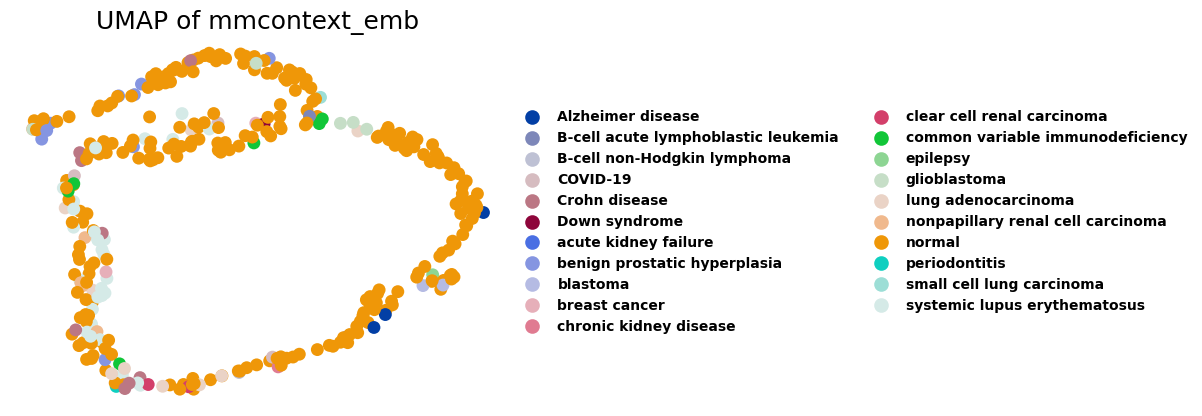

2025-02-12 13:01:11,441 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [105]:
# Visualise the embeddings
from mmcontext.pl import plot_umap

label_key = "disease"
plot_umap(adata, color_key=label_key, embedding_key="mmcontext_emb")

2025-02-12 13:01:21,847 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-12 13:01:21,847 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='X_pca'.


<Figure size 800x800 with 0 Axes>

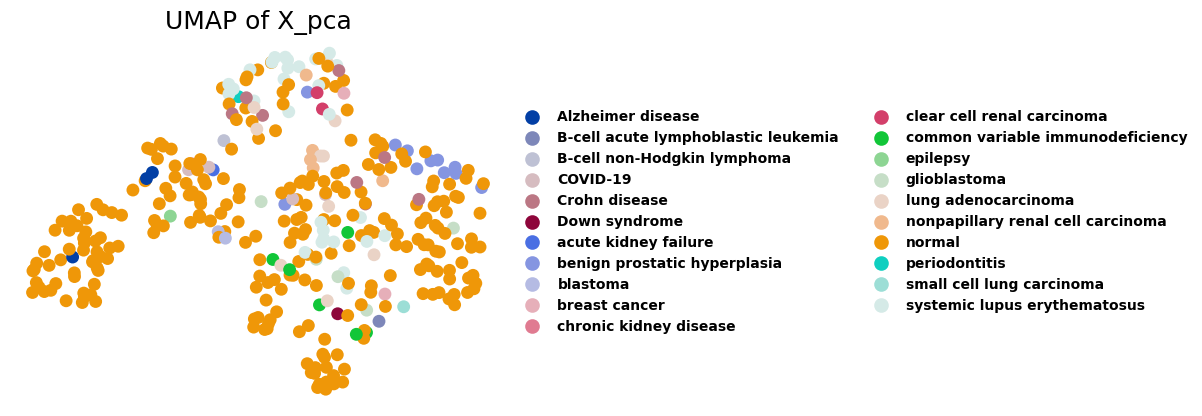

2025-02-12 13:01:22,263 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [106]:
# Visualise the embeddings
from mmcontext.pl import plot_umap

plot_umap(adata, color_key=label_key, embedding_key="X_pca")

In [107]:
labels = adata.obs[label_key].unique().tolist()
labels

['breast cancer',
 'B-cell non-Hodgkin lymphoma',
 'systemic lupus erythematosus',
 'normal',
 'nonpapillary renal cell carcinoma',
 'lung adenocarcinoma',
 'acute kidney failure',
 'benign prostatic hyperplasia',
 'Crohn disease',
 'Down syndrome',
 'epilepsy',
 'periodontitis',
 'blastoma',
 'COVID-19',
 'common variable immunodeficiency',
 'small cell lung carcinoma',
 'glioblastoma',
 'Alzheimer disease',
 'chronic kidney disease',
 'clear cell renal carcinoma',
 'B-cell acute lymphoblastic leukemia']

In [108]:
from mmcontext.engine import OmicsQueryAnnotator

annotator = OmicsQueryAnnotator(model)
annotator.annotate_omics_data(adata, labels)

2025-02-12 13:01:30,794 - mmcontext.engine.query_annotate - INFO - Using matrix multiplication to compute label similarities.
Batches: 100%|██████████| 1/1 [00:00<00:00,  3.98it/s]
2025-02-12 13:01:31,051 - mmcontext.utils - INFO - Converting numpy arrays to torch Tensors.
2025-02-12 13:01:31,051 - mmcontext.utils - INFO - L2-normalizing embeddings for cosine similarity.
2025-02-12 13:01:31,051 - mmcontext.utils - INFO - Performing matrix multiplication on device=cpu


2025-02-12 13:01:34,120 - mmcontext.pl.plotting - INFO - Starting UMAP computation and plotting.
2025-02-12 13:01:34,121 - mmcontext.pl.plotting - INFO - Computing neighbors with use_rep='mmcontext_emb'.
... storing 'best_label' as categorical


<Figure size 800x800 with 0 Axes>

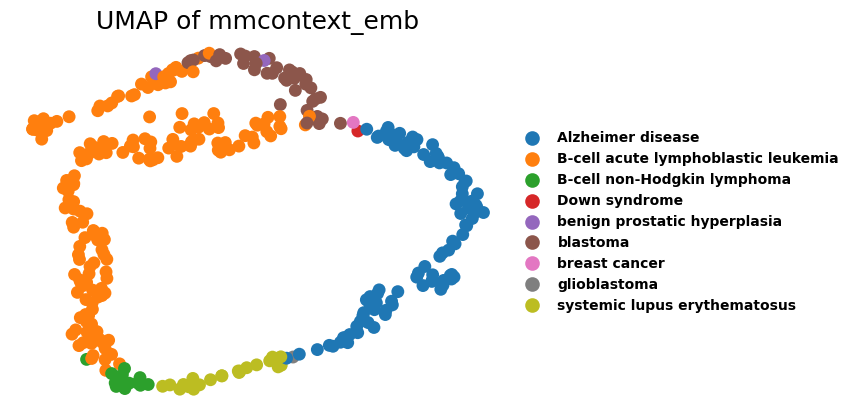

2025-02-12 13:01:34,448 - mmcontext.pl.plotting - INFO - Displayed UMAP plot interactively.


In [109]:
from mmcontext.pl import plot_umap

plot_umap(adata, color_key="best_label", embedding_key="mmcontext_emb")

In [112]:
from mmcontext.eval import evaluate_annotation_accuracy

evaluate_annotation_accuracy(adata, true_key=label_key, inferred_key="best_label")

2025-02-12 13:06:03,955 - mmcontext.eval.annotation_accuracy - INFO - Evaluating annotation accuracy for keys 'disease' and 'best_label'. Accuracy = 1.14%


0.011428571428571429